### Dependencies

In [414]:
#Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
import missingno as msno
#from datapackage import Package
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as sts
#from iso3166 import countries
#import plotly.io as pio
#import math
#from sklearn.feature_selection import f_classif
#from scipy.stats import chi2_contingency

### Import and Cleanup

In [415]:
DF = pd.read_pickle("../Data/Popularity_DF.pkl")

In [416]:
##Basic cleanup
def cleanup(DF):
    #Language fill NaN and cleanup
    DF['Language'].fillna('Unknown', inplace=True)
    DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

    #Origin Country
    DF['Origin_Country'].fillna(value='Not_Disclosed', inplace=True)

    #Create Trended_After(Days)
    def indays(x,y):
        z=x.date()-y.date()
        return z.days
    DF['Trended_After(Days)'] = DF.apply(lambda x: indays(x['First_Trending'],x['Publish_Time']), axis=1)


    #Censorship 
    DF['censorship'] = DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
    #Create output variable
    def map_to_cat(x):
        #np.quantile(Country_Category_Popularity_DF['Total_Trend_Days'], [0.95, 0.999])
        #1 -> 'JustTrending'
        #(1 to 5] -> 'Popular' #5 is 95th %
        #(5 to 14] -> 'UlraPopular' #14 is 99.1%
        #>14 -> 'Phenomenon'
        return ('JustTrending' if x==1 else ('Popular' if x<=5 else ('UltraPopular' if x<=14 else "Phenomenon")))
    DF['Popularity_Category'] = DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      

    #Drop uncecessary columns
    DF.drop(['Blocked', 'Allowed'], inplace=True, axis=1)

    #Convert Duration to minutes
    DF['Duration'] = DF['Duration']/60
    #Consider only duration <=130 (to remove live sessions)
    DF = DF[DF['Duration']<=130]

    #Reset Index
    DF.reset_index(drop=True, inplace=True)
    #Check missing values
    #_=msno.matrix(DF)
    return DF

In [417]:
DF=cleanup(DF)
num_columns=['Duration', 'Views', 'Likes', 'Dislikes', 'Comment_Count', 'Trended_After(Days)', 'PublishedAfter_in_Days']  
target=['Total_Trend_Days', 'Popularity_Category']
DF_numeric = DF[num_columns+target].copy()


# Time To trend Vs Trending Days

* Most of the trending videos were published in less than a month ago. There are only few videos those are lateblooms !
* However, given that a latebloom video is trending, the chance of this video trends >5 days increases with its age !! 

In [418]:
#Cut the number of days to start trending to 2 bins
Newness_Popularity_DF = DF.copy()
Newness_Popularity_DF['Days_to_trend']=pd.cut(Newness_Popularity_DF['Trended_After(Days)'], bins=[-1,30,np.inf],labels=['Within 1 Month', '>1 Month'])   



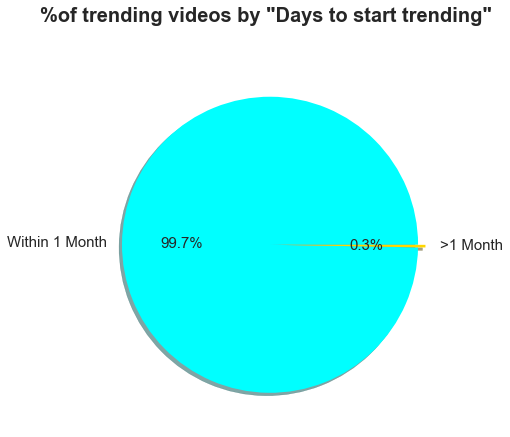

In [419]:
ax=Newness_Popularity_DF.groupby('Days_to_trend')['video_id'].count().plot(kind='pie', colors = ["cyan", "gold"], label='', fontsize=15, shadow=True, autopct='%1.1f%%', explode=[0,0.05])  
ax.set_aspect("equal")
_=plt.suptitle('%of trending videos by "Days to start trending"', fontsize=20, weight='bold', y=1.1)    
_ = plt.tight_layout()
_=plt.savefig("../Image/Perc_of_Lateblooms.png",bbox_inches = "tight")
plt.show()

In [420]:
Newness_Popularity_DF.loc[:,'Popularity_Category'] = pd.cut(Newness_Popularity_DF['Total_Trend_Days'], bins=[0,5,np.inf], labels=['Upto 5 days', '>5 Days'])

Newness_Popularity_Table=Newness_Popularity_DF.groupby(['Days_to_trend', 'Popularity_Category'])['video_id'].count().unstack()    
Newness_Popularity_Table
Newness_Popularity_Table.sum(axis=1)
Newness_Popularity_Table.apply(lambda x: 100*x/x.sum(),axis=1)

Popularity_Category,Upto 5 days,>5 Days
Days_to_trend,,
Within 1 Month,133536,5367
>1 Month,330,68


Days_to_trend
Within 1 Month    138903
>1 Month             398
dtype: int64

Popularity_Category,Upto 5 days,>5 Days
Days_to_trend,,
Within 1 Month,96.136153,3.863847
>1 Month,82.914573,17.085427


In [421]:
Labels=['<30', '(30-100]', '(100-500]', '(500-1000]', '(1000-2000]', '(2000-4000]']
Newness_Popularity_DF.loc[:,'Days_to_trend']=pd.cut(Newness_Popularity_DF['Trended_After(Days)'], bins=[-1,30,100, 500, 1000, 2000, 4000],labels=Labels) #Max is  3982 days 
Newness_Popularity_Table = Newness_Popularity_DF.groupby('Days_to_trend')['Popularity_Category'].value_counts(normalize=True).unstack(level=1).fillna(0)


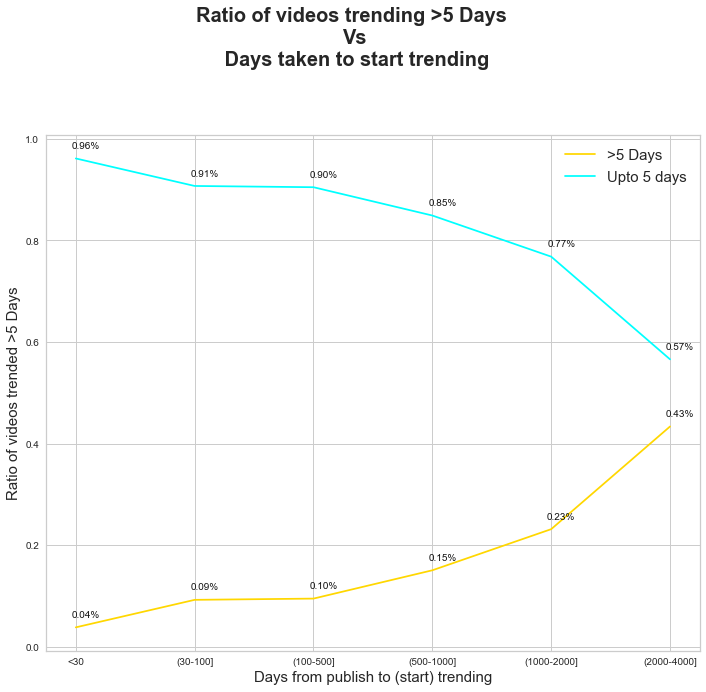

In [422]:
ax = Newness_Popularity_Table.plot(xticks=np.arange(len(Newness_Popularity_Table.index)), color = ["gold", "cyan"], figsize=(10,8))  

#Annotation
x=np.arange(len(Newness_Popularity_Table.index))
for col in Newness_Popularity_Table.columns:
    label = ["{:.2f}%".format(text) for text in Newness_Popularity_Table[col].to_list()]
    y=Newness_Popularity_Table[col].to_list()
    for index in range(len(label)):
        _=ax.annotate(label[index], # this is the text
                     (x[index],y[index]), # this is the point to label
                     textcoords="offset points", # how to position the text ('offset pixels'  is the other option)
                     xytext=(10,10), # distance from text to points (x,y)
                     ha='center', # horizontal alignment can be left, right or center
                     fontsize=10,
                     color='k') 

#Beautification !!!
_=plt.suptitle('Ratio of videos trending >5 Days \nVs\n Days taken to start trending', fontsize=20, weight='bold', y=1.2)
_=ax.legend(loc='best',fontsize = 15)
_=ax.set_ylabel('Ratio of videos trended >5 Days',fontsize = 15)
_=ax.set_xlabel('Days from publish to (start) trending',fontsize = 15)
_=plt.tight_layout()

_=plt.savefig("../Image/Latebloom_effect.png",bbox_inches = "tight")
plt.show()

# Total Views, Likes, Dislikes, Comment Count per country, and category

In [424]:
DF_FS = pd.read_pickle("../Data/Popularity_FS_DF.pkl")

In [426]:
DF_FS.reset_index(inplace=True)

In [428]:
DF_FS = cleanup(DF_FS)

KeyError: 'First_Trending'

In [432]:
DF.columns
DF.shape

Index(['video_id', 'viewing_country', 'First_Trending', 'Total_Trend_Days',
       'Video_Title', 'Publish_Time', 'PublishedAfter_in_Days',
       'Origin_Country', 'Category', 'Tags', 'Duration', 'Language', 'Views',
       'Likes', 'Dislikes', 'Comment_Count', 'Comments_Disabled',
       'Ratings_Disabled', 'Caption_Enabled', 'Video_Description',
       'Channel_Title', 'Channel_Description', 'Channel_PublishedAt',
       'Channel_Keywords', 'ChannelTopicCategories', 'GoogleAnalyticsUsed',
       'IsmoderatingComments', 'Trended_After(Days)', 'censorship',
       'Popularity_Category'],
      dtype='object')

(139301, 30)

In [431]:
DF_FS.columns

Index(['video_id', 'viewing_country', 'Total_Trend_Days', 'Video_Title',
       'Publish_Time', 'PublishedAfter_in_Days', 'Origin_Country', 'Category',
       'Tags', 'Duration', 'Language', 'Views_I', 'Views_F', 'Likes_I',
       'Likes_F', 'Dislikes_I', 'Dislikes_F', 'Comment_Count_I',
       'Comment_Count_F', 'Comments_Disabled', 'Ratings_Disabled',
       'Caption_Enabled', 'Video_Description', 'Blocked', 'Allowed',
       'Channel_Title', 'Channel_Description', 'Channel_PublishedAt',
       'Channel_Keywords', 'ChannelTopicCategories', 'GoogleAnalyticsUsed',
       'IsmoderatingComments'],
      dtype='object')